# 신경망 구현과 학습

## 스파이럴 데이터셋

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데어터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [3]:
x, t = load_data()
print('x', x.shape)  # (300, 2)
print('t', t.shape)  # (300, 3)

# pandas DataFrame으로 출력
import pandas as pd
df = pd.DataFrame(x)
df['label'] = np.argmax(t,1)
print(df['label'].value_counts())
df

x (300, 2)
t (300, 3)
2    100
1    100
0    100
Name: label, dtype: int64


,0,1,label
0,-0.000000,0.000000,0
1,-0.000977,0.009952,0
2,0.005127,0.019332,0
3,-0.000386,0.029998,0
4,0.014251,0.037375,0
...,...,...,...
295,-0.456406,0.833183,2
296,-0.630263,0.724133,2
297,-0.575706,0.780681,2
298,-0.206075,0.958088,2


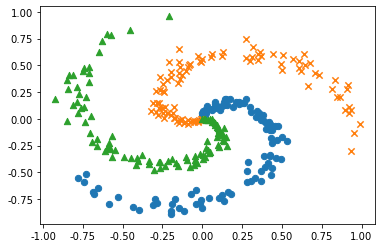

In [4]:
# 데이터 점 플롯
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
# plt.rc('font', family='Malgun Gothic')
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## 신경망 구현

In [5]:
import numpy as np
from nn_layers import Affine, Sigmoid,ReLU, SoftmaxWithLoss, SGD


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            ReLU(),
            Affine(W2, b2),
        ]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

## 학습용 코드

In [6]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 100
learning_rate = 1.0

# 데이터 읽기, 모델과 옵티마이저 생성
x, t = load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch: %d |  반복 %d / %d | loss: %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| epoch: 1 |  반복 10 / 10 | loss: 1.11
| epoch: 2 |  반복 10 / 10 | loss: 1.11
| epoch: 3 |  반복 10 / 10 | loss: 1.03
| epoch: 4 |  반복 10 / 10 | loss: 0.90
| epoch: 5 |  반복 10 / 10 | loss: 0.85
| epoch: 6 |  반복 10 / 10 | loss: 0.76
| epoch: 7 |  반복 10 / 10 | loss: 0.79
| epoch: 8 |  반복 10 / 10 | loss: 0.76
| epoch: 9 |  반복 10 / 10 | loss: 0.79
| epoch: 10 |  반복 10 / 10 | loss: 0.74
| epoch: 11 |  반복 10 / 10 | loss: 0.75
| epoch: 12 |  반복 10 / 10 | loss: 0.74
| epoch: 13 |  반복 10 / 10 | loss: 0.77
| epoch: 14 |  반복 10 / 10 | loss: 0.76
| epoch: 15 |  반복 10 / 10 | loss: 0.75
| epoch: 16 |  반복 10 / 10 | loss: 0.78
| epoch: 17 |  반복 10 / 10 | loss: 0.80
| epoch: 18 |  반복 10 / 10 | loss: 0.73
| epoch: 19 |  반복 10 / 10 | loss: 0.80
| epoch: 20 |  반복 10 / 10 | loss: 0.71
| epoch: 21 |  반복 10 / 10 | loss: 0.74
| epoch: 22 |  반복 10 / 10 | loss: 0.79
| epoch: 23 |  반복 10 / 10 | loss: 0.82
| epoch: 24 |  반복 10 / 10 | loss: 0.67
| epoch: 25 |  반복 10 / 10 | loss: 0.68
| epoch: 26 |  반복 10 / 10 | loss: 

| epoch: 233 |  반복 10 / 10 | loss: 0.06
| epoch: 234 |  반복 10 / 10 | loss: 0.07
| epoch: 235 |  반복 10 / 10 | loss: 0.07
| epoch: 236 |  반복 10 / 10 | loss: 0.06
| epoch: 237 |  반복 10 / 10 | loss: 0.05
| epoch: 238 |  반복 10 / 10 | loss: 0.05
| epoch: 239 |  반복 10 / 10 | loss: 0.06
| epoch: 240 |  반복 10 / 10 | loss: 0.05
| epoch: 241 |  반복 10 / 10 | loss: 0.08
| epoch: 242 |  반복 10 / 10 | loss: 0.06
| epoch: 243 |  반복 10 / 10 | loss: 0.06
| epoch: 244 |  반복 10 / 10 | loss: 0.06
| epoch: 245 |  반복 10 / 10 | loss: 0.05
| epoch: 246 |  반복 10 / 10 | loss: 0.07
| epoch: 247 |  반복 10 / 10 | loss: 0.05
| epoch: 248 |  반복 10 / 10 | loss: 0.04
| epoch: 249 |  반복 10 / 10 | loss: 0.08
| epoch: 250 |  반복 10 / 10 | loss: 0.06
| epoch: 251 |  반복 10 / 10 | loss: 0.06
| epoch: 252 |  반복 10 / 10 | loss: 0.05
| epoch: 253 |  반복 10 / 10 | loss: 0.06
| epoch: 254 |  반복 10 / 10 | loss: 0.05
| epoch: 255 |  반복 10 / 10 | loss: 0.07
| epoch: 256 |  반복 10 / 10 | loss: 0.06
| epoch: 257 |  반복 10 / 10 | loss: 0.06


In [7]:
np.random.permutation(10)  # 0에서 9까지의 무작위 순서를 생성해서 반환

array([4, 6, 5, 2, 7, 0, 1, 8, 3, 9])

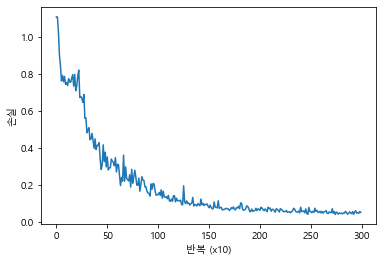

In [8]:
# 학습 결과 플롯
plt.rc('font', family='Malgun Gothic')
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('반복 (x10)')
plt.ylabel('손실')
plt.show()

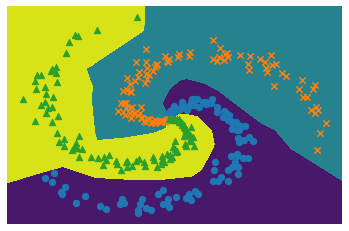

In [9]:
# 경계 영역 플롯 : Decision Boundary(결정 경계)
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()


In [10]:
a = np.arange(12).reshape(3,4)
print('원본:\n',a)
a[a<=5] = 0    # 불린 인덱스
print('변환:\n',a)

원본:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
변환:
 [[ 0  0  0  0]
 [ 0  0  6  7]
 [ 8  9 10 11]]
